In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as FF
import torch.optim as optim

from torchvision import transforms

In [2]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Generator

In [12]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1),
                nn.Tanh()
        )

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 転置畳み込み層に入れるためにテンソルの形を整形
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)

        return out

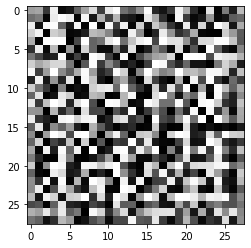

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

input_z = torch.randn(2, 20)

fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# Discriminator

In [16]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=4,
                    stride=2,padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=4,
                    stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True)
        )

        self.z_layer1 = nn.Linear(z_dim, 512)

        self.last1 = nn.Sequential(
            nn.Linear(3648,1024),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last2 = nn.Linear(1024,1)

    def forward(self, x, z):

        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out

        feature = feature.view(feature.size()[0], -1)

        out = self.last2(out)

        return out, feature

In [25]:
D = Discriminator(z_dim=20)

input_z = torch.randn(2, 20)
fake_images = G(input_z)

fake_images = G(input_z)

d_out, _ = D(fake_images, input_z)

print(nn.Sigmoid()(d_out))

tensor([[0.5579],
        [0.5507]], grad_fn=<SigmoidBackward>)


# Encoder

In [26]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,
                    stride=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,
                    stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,
                    stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last = nn.Linear(128*7*7,z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(-1,128*7*7)
        out = self.last(out)

        return out

In [41]:
E = Encoder(z_dim=20)

x = fake_images

z = E(x)

print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[ 0.0690,  0.2678, -0.4826, -0.1528,  0.1303, -0.2641, -0.4296,  0.7629,
         -0.0215,  0.7813,  0.0345,  0.1489, -1.2330,  0.1028, -0.0897,  0.1279,
         -0.2455, -1.1458, -0.1089, -0.3185],
        [-0.1693, -0.5945, -0.0973, -0.7662,  0.0185, -0.1420, -0.1820,  0.4278,
         -0.1888,  0.1832, -0.0620, -0.2926, -0.1563, -0.6806, -0.3959, -0.0669,
         -0.0885, -0.7621,  0.2679, -0.6619]], grad_fn=<AddmmBackward>)


In [42]:
def make_datapath_list():

    train_img_list = list()

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [43]:
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [44]:
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img)

        return img_transformed

In [45]:
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list = train_img_list, transform=ImageTransform(mean, std)
)

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 28, 28])


In [47]:
torch.cuda.is_available()  

False

In [48]:
def train_model(G, D, E, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:",device)

    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1,beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1,beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_ge, [beta1,beta2])


    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    E.to(device)
    D.to(device)

    G.train()
    E.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_e_loss = 0.0
        epoch_d_loss = 0.0

        print("-------------------")
        print(f"Epoch {epoch}/{num_epochs}")
        print("-------------------")
        print("train")

        for imges in dataloader:


            if imges.size()[0] == 1:
                continue


            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size), 1).to(device)
            label_fake = torch.full((mini_batch_size), 0).to(device)

            imges = imges.to(device)

            # Discriminator

            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            input_z = torch.randn(mini_batch_size, z_dim).to(device)

            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1),label_fake)
            d_loss = d_loss_real + d_loss_fake

            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Generator
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # Encoder
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            e_loss = criterion(d_out_real.view(-1), label_fake)

            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()


            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1


        t_epoch_finish = time.time()
        print("-------------------")
        print(f"epoch {epoch}|| Epoch D loss:{epoch_d_loss/batch_size:.4f} || Epoch G loss:{epoch_g_loss/batch_size:.4f} || Epoch E loss:{epoch_e_loss/batch_size:.4f}")
        t_epoch_start = time.time()

        print("Iteration:",iteration)

        return G ,D , E

In [49]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)

In [50]:
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (x_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (z_layer1): Linear(in_features=20, out_features=512, bias=True)
  (last1): Sequential(
    (0): Linear(in_features=3648, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last2): Linear(in_features=1024, out_features=1, bias=True)
)